In [1]:
import json
import yaml
import numpy as np
import shutil
from pathlib import Path
import pandas as pd
from mouselab.mouselab import MouselabEnv
from mouselab.env_utils import get_ground_truths_from_json
import dill as pickle
from collections import Counter
from costometer.utils.analysis_utils import AnalysisObject

# Creating data, modifying code

In [2]:
discount_factors = [.10, .20, .30, .40, .50,.75,.85,.9,.95,.975,.999]
alphas = [0.0,.25,.5,.75,.9]

In [3]:
for discount_factor in discount_factors:
    shutil.copyfile( Path(f"../../../data/inputs/exp_inputs/structure/312_2_4_24.json"), \
                     Path(f"../../../data/inputs/exp_inputs/structure/high_increasing{discount_factor}.json"))

In [4]:
with open(Path("../../../data/inputs/yamls/experiment_settings/high_increasing.yaml"), "rb") as f:
    experiment_setting_data = yaml.safe_load(f)
    
for discount_factor in discount_factors:
    experiment_setting_data["ground_truth_file"] = f"high_increasing{discount_factor}"
    experiment_setting_data["structure"] = f"high_increasing{discount_factor}"
    
    with open(Path(f"../../../data/inputs/yamls/experiment_settings/high_increasing{discount_factor}.yaml"), "w") as f:
        yaml.dump(experiment_setting_data, f)

In [5]:
env = MouselabEnv.new_symmetric_registered("high_increasing")

for discount_factor in discount_factors:
    with open(Path("../../../data/inputs/exp_inputs/rewards/312_2_4_24.json"), "rb") as f:
        data = json.load(f)
    
    for trial in data:
        trial["stateRewards"] = [round(reward*discount_factor**(env.mdp_graph.nodes[action]["depth"]-1),2) if env.mdp_graph.nodes[action]["depth"] != 0 else 0.0 for action, reward in enumerate(trial["stateRewards"])]

    with open(Path(f"../../../data/inputs/exp_inputs/rewards/high_increasing{discount_factor}.json"), "w") as f:
        json.dump(data, f)

In [6]:
ls ../../../data/inputs/yamls/experiments

c1.1.yaml                    methods_main0.9.yaml
c2.1.yaml                    methods_main0.95.yaml
irl_validation.yaml          methods_main0.975.yaml
methods_main.yaml            methods_main0.999.yaml
methods_main0.1.yaml         methods_main_extension.yaml
methods_main0.2.yaml         methods_main_transfer.yaml
methods_main0.3.yaml         quest_feasibility.yaml
methods_main0.4.yaml         quest_first.yaml
methods_main0.5.yaml         quest_main.yaml
methods_main0.75.yaml        quest_second.yaml
methods_main0.85.yaml


In [7]:
with open(Path("../../../data/inputs/yamls/experiments/methods_main.yaml"), "rb") as f:
    data = yaml.safe_load(f)

for discount_factor in discount_factors:
    data['sessions'] = [f'methods_main{discount_factor}']
    data['experiment_setting'] = f'high_increasing{discount_factor}'
    with open(Path(f"../../../data/inputs/yamls/experiments/methods_main{discount_factor}.yaml"), "w") as f:
        yaml.dump(data, f)

Put this in `cluster/src/cluster_utils.py`

In [8]:
for discount_factor in discount_factors:
    print(f"elif name == 'high_increasing{discount_factor}':\n"
          f"    register(\n"
          f"        name=name,\n"
          f"        branching=[3, 1, 2],\n"
          f"        reward_inputs=\"depth\",\n"
          f"        reward_dictionary={{\n"
          f"            1: Categorical([-4, -2, 2, 4]),\n"
          f"            2: Categorical([{', '.join(str(round(val*discount_factor,2)) for val in [-8, -4, 4, 8])}]),\n"
          f"            3: Categorical([{', '.join(str(round(val*discount_factor**2,2)) for val in [-48, -24, 24, 48])}]),\n"
          f"        }},\n"
          f"    )")

elif name == 'high_increasing0.1':
    register(
        name=name,
        branching=[3, 1, 2],
        reward_inputs="depth",
        reward_dictionary={
            1: Categorical([-4, -2, 2, 4]),
            2: Categorical([-0.8, -0.4, 0.4, 0.8]),
            3: Categorical([-0.48, -0.24, 0.24, 0.48]),
        },
    )
elif name == 'high_increasing0.2':
    register(
        name=name,
        branching=[3, 1, 2],
        reward_inputs="depth",
        reward_dictionary={
            1: Categorical([-4, -2, 2, 4]),
            2: Categorical([-1.6, -0.8, 0.8, 1.6]),
            3: Categorical([-1.92, -0.96, 0.96, 1.92]),
        },
    )
elif name == 'high_increasing0.3':
    register(
        name=name,
        branching=[3, 1, 2],
        reward_inputs="depth",
        reward_dictionary={
            1: Categorical([-4, -2, 2, 4]),
            2: Categorical([-2.4, -1.2, 1.2, 2.4]),
            3: Categorical([-4.32, -2.16, 2.16, 4.32]),
        },
    )
elif name == 'high_increa

In [9]:
mouselab_data = pd.read_csv(Path("../../../data/processed/methods_main/mouselab-mdp.csv"), index_col=0)
mouselab_data = mouselab_data[mouselab_data["block"]=="test"]
for discount_factor in discount_factors:
    with open(Path(f"../../../data/inputs/exp_inputs/rewards/high_increasing{discount_factor}.json"), "rb") as f:
        data = json.load(f)
    ground_truth_dict = {trial["trial_id"] : trial["stateRewards"] for trial in data}

    mouselab_data["state_rewards"] = mouselab_data["trial_id"].apply(lambda trial_id : ground_truth_dict[trial_id][1:])
    
    # need to change ground truths
    Path(f"../../../data/processed/methods_main{discount_factor}").mkdir(exist_ok = True, parents=True)
    mouselab_data.to_csv(Path(f"../../../data/processed/methods_main{discount_factor}/mouselab-mdp.csv"), index=False)

Generate cluster submission commands to run to get Q values

In [10]:
print(f"for experiment_setting in high_increasing {' '.join(['high_increasing' + str(discount_factor) for discount_factor in discount_factors])};\n"
      f"    do for alpha in 1 {' '.join([str(alpha) for alpha in alphas])};\n"
      f"        do condor_submit_bid 2 submission_scripts/MPI-IS/03_Get_Q_Values.sub experiment_setting=$experiment_settin cost_function=back_dist_depth_eff_forw param_file=back_dist_depth_eff_forw alpha=$alpha;\n"
      f"done; done;")

for experiment_setting in high_increasing high_increasing0.1 high_increasing0.2 high_increasing0.3 high_increasing0.4 high_increasing0.5 high_increasing0.75 high_increasing0.85 high_increasing0.9 high_increasing0.95 high_increasing0.975 high_increasing0.999;
    do for alpha in 1 0.0 0.25 0.5 0.75 0.9;
        do condor_submit_bid 2 submission_scripts/MPI-IS/03_Get_Q_Values.sub experiment_setting=$experiment_settin cost_function=back_dist_depth_eff_forw param_file=back_dist_depth_eff_forw alpha=$alpha;
done; done;


Generate cluster submission commands to infer likelihood for methods_main:

In [11]:
print(f"for experiment in methods_main {' '.join(['methods_main' + str(discount_factor) for discount_factor in discount_factors])};\n"
      f"    do for alpha in 1 {' '.join([str(alpha) for alpha in alphas])};\n"
      f"        do condor_submit_bid 2 submission_scripts/MPI-IS/04_Infer_Params.sub experiment=$experiment cost_function=back_dist_depth_eff_forw param_file=dist_forw_eff alpha=$alpha;\n"
      f"done; done;")

for experiment in methods_main methods_main0.1 methods_main0.2 methods_main0.3 methods_main0.4 methods_main0.5 methods_main0.75 methods_main0.85 methods_main0.9 methods_main0.95 methods_main0.975 methods_main0.999;
    do for alpha in 1 0.0 0.25 0.5 0.75 0.9;
        do condor_submit_bid 2 submission_scripts/MPI-IS/04_Infer_Params.sub experiment=$experiment cost_function=back_dist_depth_eff_forw param_file=dist_forw_eff alpha=$alpha;
done; done;


Combine data:

In [12]:
print(f"for experiment in methods_main {' '.join(['methods_main' + str(discount_factor) for discount_factor in discount_factors])};\n"
      f"    do for alpha in 1 {' '.join([str(alpha) for alpha in alphas])};\n"
      f"        do condor_submit_bid 2 submission_scripts/MPI-IS/05_Combine_Human.sub experiment=$experiment cost_function=dist_forw_eff alpha=$alpha;\n"
      f"done; done;")

for experiment in methods_main methods_main0.1 methods_main0.2 methods_main0.3 methods_main0.4 methods_main0.5 methods_main0.75 methods_main0.85 methods_main0.9 methods_main0.95 methods_main0.975 methods_main0.999;
    do for alpha in 1 0.0 0.25 0.5 0.75 0.9;
        do condor_submit_bid 2 submission_scripts/MPI-IS/05_Combine_Human.sub experiment=$experiment cost_function=dist_forw_eff alpha=$alpha;
done; done;


MAP:

In [13]:
print(f"for experiment in methods_main {' '.join(['methods_main' + str(discount_factor) for discount_factor in discount_factors])};\n"
      f"    do for alpha in 1 {' '.join([str(alpha) for alpha in alphas])};\n"
      f"        do condor_submit_bid 2 submission_scripts/MPI-IS/M_01_Get_MAP_File_by_PID.sub pid_file=methods_main pid_file=methods_main experiment=$experiment cost_function=dist_forw_eff alpha=$alpha;\n"
      f"done; done;")

for experiment in methods_main methods_main0.1 methods_main0.2 methods_main0.3 methods_main0.4 methods_main0.5 methods_main0.75 methods_main0.85 methods_main0.9 methods_main0.95 methods_main0.975 methods_main0.999;
    do for alpha in 1 0.0 0.25 0.5 0.75 0.9;
        do condor_submit_bid 2 submission_scripts/MPI-IS/M_01_Get_MAP_File_by_PID.sub pid_file=methods_main pid_file=methods_main experiment=$experiment cost_function=dist_forw_eff alpha=$alpha;
done; done;


In [14]:
with open(Path("../../../analysis/methods/static/inputs/yamls/NoDepth.yaml"), "rb") as f:
    analysis_setting = yaml.safe_load(f)
  
for experiment_suffix in [""] + discount_factors:
    params = [f"{experiment_suffix}{alpha_suffix}" for alpha_suffix in [""] + [f"_{alpha}" for alpha in alphas]]

    analysis_setting["params"] = params
    
    with open(Path(f"../../../analysis/methods/static/inputs/yamls/DiscountFactor{experiment_suffix}.yaml"), "w") as f:
        yaml.dump(analysis_setting, f)

In [15]:
experiment_val_dict = {} 
alpha_val_dict = {}
for experiment_val, experiment_suffix in zip([1]+ discount_factors, [""] + discount_factors):
    for alpha_val, alpha_suffix in zip([1] + alphas, [""] + [f"_{alpha}" for alpha in alphas]):
        experiment_val_dict[f"{experiment_suffix}{alpha_suffix}"] = experiment_val
        alpha_val_dict[f"{experiment_suffix}{alpha_suffix}"] = alpha_val

Transfer over:

```
rsync -aPzr --include "methods_main*/*/*mle_and_map*" --include "*/" --exclude "*" vfelso@login.cluster.is.localnet:/work/vfelso/planning-depth-differences/data/processed/ data/processed
```

# Fit of main dataset by discount factor + power utility function model instead of depth in winning model

Distance, Effort, Depth and Forward Search Bonus              40490.81774

In [16]:
# optimization_dfs = []

# for experiment_suffix in [""] + discount_factors:
#     analysis_obj = AnalysisObject(f"DiscountFactor{experiment_suffix}", irl_path=Path("../../..").resolve(), experiment_subdirectory="methods/static")

#     optimization_data = analysis_obj.query_optimization_data(include_null=False)
#     optimization_data=optimization_data[optimization_data["Model Name"]=="Distance and Effort Costs with Forward Search Bonus"]

#     optimization_dfs.append(optimization_data)

# optimization_dfs = pd.concat(optimization_dfs)

# optimization_dfs.to_csv("discount_factors.csv")

In [17]:
optimization_dfs = pd.read_csv("discount_factors.csv")
optimization_dfs["session"]=optimization_dfs["session"].fillna("")

In [18]:
optimization_dfs=optimization_dfs.reset_index()
best_param_rows = optimization_dfs.loc[
    optimization_dfs.groupby(["trace_pid"]).idxmax()["value"]
]

/var/folders/y7/qnlh5f453nxbc7w72qw0lw340000gn/T/ipykernel_9843/2653243916.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.idxmax is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  optimization_dfs.groupby(["trace_pid"]).idxmax()["value"]


In [19]:
best_param_rows.groupby(["session"]).count().sort_values(by="trace_pid")

,index,Unnamed: 0,trace_pid,temp,back_added_cost,depth_cost_weight,distance_multiplier,forw_added_cost,given_cost,applied_policy,Model Name,Number Parameters,metric,value,Block,Number Trials,Prior,Group,cost_function,bic
session,,,,,,,,,,,,,,,,,,,,
0.9_0.25,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.4_0.9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.4_0.75,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.75_0.9,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.85,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.3_0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.75,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.75_0.25,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0.95,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [20]:
from statsmodels.tools.eval_measures import bic

best_param_rows["bic"] = best_param_rows.apply(
    lambda row: bic(
    llf=row["value"],
    nobs=20,
    df_modelwc=6, # temp, discount rate, alpha, forw, eff, dist\n",
    ),
    axis=1)
    
best_param_rows.sum()["bic"]

35502.696483835905

In [21]:
optimization_dfs.groupby(["session"]).sum().sort_values(by="bic")

/var/folders/y7/qnlh5f453nxbc7w72qw0lw340000gn/T/ipykernel_9843/2555403383.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  optimization_dfs.groupby(["session"]).sum().sort_values(by="bic")


,index,Unnamed: 0,trace_pid,temp,back_added_cost,depth_cost_weight,distance_multiplier,forw_added_cost,given_cost,Number Parameters,value,Number Trials,Group,bic
session,,,,,,,,,,,,,,
0.75_0.0,558089,1095499,276339,213.75,0.0,0.0,170.5,-275.5,232.0,488,-18477.970794,2440,0,38417.858938
0.75_0.25,572973,1824815,276339,220.05,0.0,0.0,178.0,-278.0,233.0,488,-18508.765779,2440,0,38479.448908
0.75_0.5,587857,2554131,276339,244.45,0.0,0.0,203.5,-295.5,236.0,488,-18653.387576,2440,0,38768.692501
0.85_0.0,647393,1095499,276339,285.65,0.0,0.0,256.5,-303.5,190.5,488,-18714.590573,2440,0,38891.098495
0.5_0.9,528321,4012763,276339,171.15,0.0,0.0,125.0,-237.0,246.5,488,-18760.131093,2440,0,38982.179536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.1_0.5,141337,2554131,276339,658.40,0.0,0.0,128.0,-139.5,578.5,488,-25792.806781,2440,0,53047.530911
0.1_0.0,111569,1095499,276339,528.20,0.0,0.0,112.5,-151.5,455.5,488,-25795.599115,2440,0,53053.115579
0.1_0.75,156221,3283447,276339,715.65,0.0,0.0,137.0,-143.5,636.5,488,-25906.269497,2440,0,53274.456344


In [22]:
best_param_rows["alpha"] = best_param_rows["session"].apply(lambda session: alpha_val_dict[session])
best_param_rows["discount_factor"] = best_param_rows["session"].apply(lambda session: experiment_val_dict[session])

In [23]:
np.mean(best_param_rows["alpha"]), np.std(best_param_rows["alpha"])

(0.6413934426229508, 0.42415260858190756)

In [24]:
Counter(best_param_rows["alpha"])

Counter({1.0: 49, 0.0: 32, 0.5: 6, 0.9: 20, 0.25: 6, 0.75: 9})

In [25]:
np.mean(best_param_rows["discount_factor"]), np.std(best_param_rows["discount_factor"])

(0.7409590163934426, 0.33280884577868525)

In [26]:
Counter(best_param_rows["discount_factor"])

Counter({0.999: 28,
         0.975: 7,
         0.3: 5,
         1.0: 27,
         0.1: 11,
         0.9: 7,
         0.95: 3,
         0.4: 11,
         0.5: 5,
         0.2: 7,
         0.75: 8,
         0.85: 3})

In [27]:
np.mean(best_param_rows["temp"]), np.std(best_param_rows["temp"])

(1.0909836065573773, 0.8520711601892984)

# Simulations

In [28]:
print(f"for experiment_setting in high_increasing {' '.join(['high_increasing' + str(discount_factor) for discount_factor in discount_factors])};\n"
      f"    do for alpha in 1 {' '.join([str(alpha) for alpha in alphas])};\n"
      f"        do condor_submit_bid 2 submission_scripts/MPI-IS/06_Simulate_Optimal.sub experiment_setting=$experiment_setting cost_function=back_dist_depth_eff_forw param_file=null alpha=$alpha;\n"
      f"done; done;")

for experiment_setting in high_increasing high_increasing0.1 high_increasing0.2 high_increasing0.3 high_increasing0.4 high_increasing0.5 high_increasing0.75 high_increasing0.85 high_increasing0.9 high_increasing0.95 high_increasing0.975 high_increasing0.999;
    do for alpha in 1 0.0 0.25 0.5 0.75 0.9;
        do condor_submit_bid 2 submission_scripts/MPI-IS/06_Simulate_Optimal.sub experiment_setting=$experiment_setting cost_function=back_dist_depth_eff_forw param_file=null alpha=$alpha;
done; done;


```
rsync -aPzr --include "high_increasing*/OptimalQ/simulated_agents_back_dist_depth_eff_forw*" --include "*/" --exclude "*" vfelso@login.cluster.is.localnet:/work/vfelso/planning-depth-differences/cluster/data/trajectories/ cluster/data/trajectories
```


# Look at simulations

In [29]:
depth_data = pd.concat([pd.read_csv(f, index_col=0) for f in Path("../../../cluster/data/trajectories/high_increasing/OptimalQ/").glob("simulated_agents_linear_depth_*_91.00.csv")])
depth_only_data = pd.concat([pd.read_csv(f, index_col=0) for f in Path("../../../cluster/data/trajectories/high_increasing/OptimalQ/").glob("simulated_agents_depth_only_*_91.00.csv")])

In [30]:
depth_data.groupby(["sim_depth_cost_weight"]).mean()

/var/folders/y7/qnlh5f453nxbc7w72qw0lw340000gn/T/ipykernel_9843/1404556213.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  depth_data.groupby(["sim_depth_cost_weight"]).mean()


,n_steps,i_episode,finished,return,trial_id,actions,rewards,sim_exact,sim_temperature_file,sim_num_simulated,sim_num_trials,sim_seed,sim_static_cost_weight,pid
sim_depth_cost_weight,,,,,,,,,,,,,,
-5.0,13.696003,9.501049,1.0,170.873703,1.146243e+17,7.058490,13.371199,0.0,NaN,54.221865,20.0,91.0,1.063876,26.612189
-2.5,13.517600,9.515829,1.0,107.983296,7.307269e+16,7.099310,8.630997,0.0,NaN,56.560678,20.0,91.0,0.728505,27.776230
-1.0,12.684407,9.509322,1.0,70.870104,1.363922e+17,7.279407,6.159043,0.0,NaN,55.684120,20.0,91.0,0.547208,27.326802
-0.1,11.905653,9.476758,1.0,57.395145,4.704697e+17,7.508223,5.878279,0.0,NaN,10.000000,20.0,91.0,-0.022484,4.502905
0.0,9.723910,9.529295,1.0,50.710475,4.196647e+17,8.005750,7.395792,0.0,NaN,39.757557,20.0,91.0,0.271548,19.440438
0.1,10.215781,9.452049,1.0,54.658385,4.584939e+17,7.869466,7.012584,0.0,NaN,10.000000,20.0,91.0,-0.023157,4.502474
0.5,9.653321,9.517381,1.0,46.814723,4.056651e+17,7.974976,6.552327,0.0,NaN,10.000000,20.0,91.0,0.030522,4.473556
1.0,7.842421,9.490656,1.0,34.882873,4.328797e+17,8.421235,6.828057,0.0,NaN,46.116743,20.0,91.0,0.342109,22.622292
2.5,6.477913,9.535244,1.0,13.882179,1.760264e+17,8.746095,4.689004,0.0,NaN,51.102402,20.0,91.0,0.559582,25.214378


In [31]:
depth_only_data.groupby(["sim_depth_cost_weight"]).mean()

/var/folders/y7/qnlh5f453nxbc7w72qw0lw340000gn/T/ipykernel_9843/2914157578.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  depth_only_data.groupby(["sim_depth_cost_weight"]).mean()


,n_steps,i_episode,finished,return,trial_id,actions,rewards,sim_exact,sim_temperature_file,sim_cost_parameter_values,sim_num_simulated,sim_num_trials,sim_seed,pid
sim_depth_cost_weight,,,,,,,,,,,,,,
-5.0,11.219890,9.495930,1.0,113.074833,1.788010e+17,7.551589,11.095626,0.0,NaN,-5.0,100.0,20.0,91.0,49.564535
-2.5,11.240762,9.498116,1.0,75.289536,1.169812e+17,7.545935,7.376487,0.0,NaN,-2.5,100.0,20.0,91.0,49.522197
-1.0,10.221193,9.532738,1.0,52.700149,2.201080e+17,7.718683,5.806498,0.0,NaN,-1.0,100.0,20.0,91.0,49.693309
0.0,6.278772,9.443878,1.0,38.413891,2.443176e+17,8.876141,9.982103,0.0,NaN,0.0,100.0,20.0,91.0,49.568211
1.0,6.266260,9.451893,1.0,29.799602,6.096593e+17,8.870972,8.274698,0.0,NaN,1.0,100.0,20.0,91.0,49.681706
2.5,6.054337,9.507554,1.0,19.120614,2.966608e+17,8.935916,6.570967,0.0,NaN,2.5,100.0,20.0,91.0,49.063962
5.0,6.117969,9.534557,1.0,0.403003,3.319853e+17,8.849500,2.752860,0.0,NaN,5.0,100.0,20.0,91.0,49.481173
7.5,4.199356,9.428418,1.0,0.105941,3.002324e+16,9.760558,2.525412,0.0,NaN,7.5,100.0,20.0,91.0,49.544381
10.0,4.219843,9.468772,1.0,-11.576017,5.926656e+16,9.750892,-0.914347,0.0,NaN,10.0,100.0,20.0,91.0,49.325125


In [32]:
discount_data = []
for discount_factor, experiment_suffix in zip([1] + discount_factors, [""] + discount_factors):
    for alpha, alpha_suffix in zip([1]+alphas, [""] + [f"_{alpha}" for alpha in alphas]):
        curr_df = pd.read_csv(f"../../../cluster/data/trajectories/high_increasing{experiment_suffix}{alpha_suffix}/OptimalQ/simulated_agents_back_dist_depth_eff_forw_0.00_0.00_0.00_0.00_1.00_91.00.csv", index_col=0) 
        curr_df["discount_factor"] = discount_factor
        curr_df["alpha"] = alpha
        discount_data.append(curr_df)
discount_data = pd.concat(discount_data)

In [33]:
discount_data.groupby(["discount_factor", "alpha"]).mean()

/var/folders/y7/qnlh5f453nxbc7w72qw0lw340000gn/T/ipykernel_9843/3836188975.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  discount_data.groupby(["discount_factor", "alpha"]).mean()


n_steps  i_episode  finished     return      trial_id  \
discount_factor alpha                                                           
0.1             0.00   3.619048   9.482143       1.0   0.503968 -1.882007e+17   
                0.25   3.642436   9.351670       1.0   0.440079 -9.922029e+16   
                0.50   3.570850   9.246964       1.0   0.676113  6.087526e+16   
                0.75   3.604790   9.636727       1.0   0.335329  5.862370e+17   
                0.90   3.575758   9.579798       1.0   0.791919  6.288288e+17   
...                         ...        ...       ...        ...           ...   
1.0             0.25   6.399067   8.884481       1.0  37.024504  1.157205e+18   
                0.50   6.518602   9.545660       1.0  36.919955  1.971777e+17   
                0.75   6.399530   9.598120       1.0  36.770858  4.011088e+17   
                0.90   6.042660   9.340025       1.0  38.878294  1.242264e+17   
                1.00   6.310427   9.665877       1.0  37.808057  6.684998e+17   

                        actions    rewards  sim_exact  sim_temperature_file  \
discount_factor alpha                                                         
0.1             0.00   8.444444   0.301587        0.0                   NaN   
                0.25   8.324165   0.269155        0.0                   NaN   
                0.50   8.514170   0.380567        0.0                   NaN   
                0.75   8.433134   0.241517        0.0                   NaN   
                0.90   8.410101   0.410101        0.0                   NaN   
...                         ...        ...        ...                   ...   
1.0             0.25   8.809802   9.616103        0.0                   NaN   
                0.50   8.795941   9.257046        0.0                   NaN   
                0.75   8.874266   9.686251        0.0                   NaN   
                0.90   8.959849  10.656211        0.0                   NaN   
                1.00   8.798578   9.921801        0.0                   NaN   

                       sim_num_simulated  sim_num_trials  sim_seed  sim_alpha  \
discount_factor alpha                                                           
0.1             0.00                10.0            20.0      91.0       0.00   
                0.25                10.0            20.0      91.0       0.25   
                0.50                10.0            20.0      91.0       0.50   
                0.75                10.0            20.0      91.0       0.75   
                0.90                10.0            20.0      91.0       0.90   
...                                  ...             ...       ...        ...   
1.0             0.25                10.0            20.0      91.0       0.25   
                0.50                10.0            20.0      91.0       0.50   
                0.75                10.0            20.0      91.0       0.75   
                0.90                10.0            20.0      91.0       0.90   
                1.00                10.0            20.0      91.0       1.00   

                       sim_back_added_cost  sim_depth_cost_weight  \
discount_factor alpha                                               
0.1             0.00                   0.0                    0.0   
                0.25                   0.0                    0.0   
                0.50                   0.0                    0.0   
                0.75                   0.0                    0.0   
                0.90                   0.0                    0.0   
...                                    ...                    ...   
1.0             0.25                   0.0                    0.0   
                0.50                   0.0                    0.0   
                0.75                   0.0                    0.0   
                0.90                   0.0                    0.0   
                1.00                   0.0                  

In [34]:
sim_cost_parameters={}
for cost_function in ["linear_depth", "back_dist_depth_eff_forw"]:
    yaml_file = Path(
                        f"../../../data/inputs/yamls/cost_functions/{cost_function}.yaml"
                    )
    with open(str(yaml_file), "r") as stream:
        cost_details = yaml.safe_load(stream)

    sim_cost_parameters[cost_function] = [
                                        f"sim_{param}" for param in cost_details["constant_values"].keys()
                                        ]

In [35]:
for classification, nodes in experiment_setting_data[
    "node_classification"
].items():
    discount_data[classification] = discount_data["actions"].apply(
        lambda action: action in nodes
    )
    depth_only_data[classification] = depth_only_data["actions"].apply(
        lambda action: action in nodes
    )
    depth_data[classification] = depth_data["actions"].apply(
        lambda action: action in nodes
    )

sum_discount_clicks = (
    discount_data.groupby(["pid", "i_episode", *sim_cost_parameters["back_dist_depth_eff_forw"], "discount_factor", "alpha"])
    .sum()
    .reset_index()
    .groupby([*sim_cost_parameters["back_dist_depth_eff_forw"], "discount_factor", "alpha"])
    .mean()
    .reset_index()
)

sum_depth_clicks = (
    depth_data.groupby(["pid", "i_episode", *sim_cost_parameters["linear_depth"]])
    .sum()
    .reset_index()
    .groupby([ *sim_cost_parameters["linear_depth"]])
    .mean()
    .reset_index()
)

/var/folders/y7/qnlh5f453nxbc7w72qw0lw340000gn/T/ipykernel_9843/4156878551.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  discount_data.groupby(["pid", "i_episode", *sim_cost_parameters["back_dist_depth_eff_forw"], "discount_factor", "alpha"])
/var/folders/y7/qnlh5f453nxbc7w72qw0lw340000gn/T/ipykernel_9843/4156878551.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  depth_data.groupby(["pid", "i_episode", *sim_cost_parameters["linear_depth"]])


In [36]:
sum_depth_clicks.groupby([ "sim_depth_cost_weight"]).mean()[["early", "middle", "late", "clicks"]]

,early,middle,late,clicks
sim_depth_cost_weight,,,,
-5.0,2.385833,2.912083,6.000000,11.297917
-2.5,2.134583,2.441667,5.614167,10.190417
-1.0,1.883542,2.103750,5.269583,9.256875
-0.1,1.375000,1.545417,4.541250,7.461667
0.0,1.126792,1.195042,4.211083,6.532917
0.1,0.867500,0.844583,3.857083,5.569167
0.5,0.752917,0.725000,3.682917,5.160833
1.0,0.610833,0.562083,3.367625,4.540542
2.5,0.365833,0.186500,2.830875,3.383208


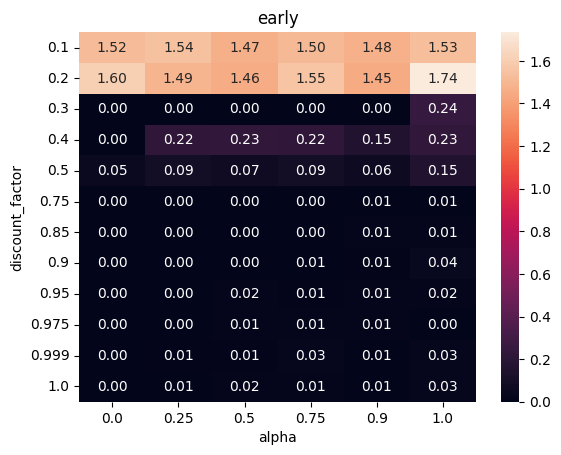

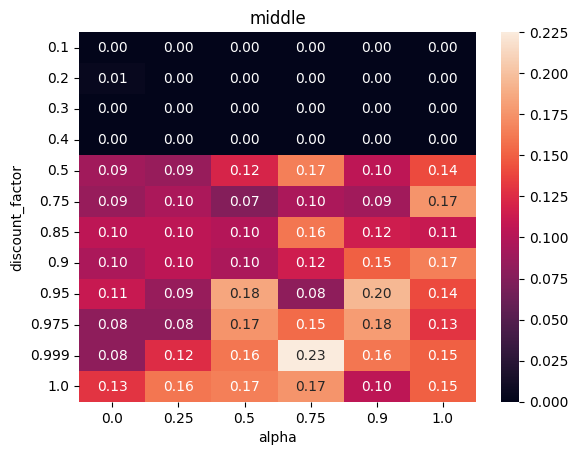

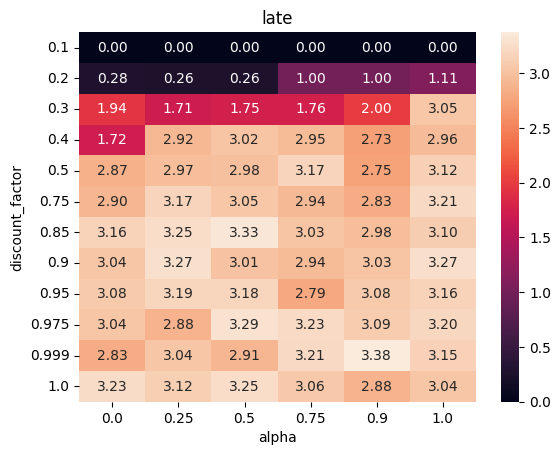

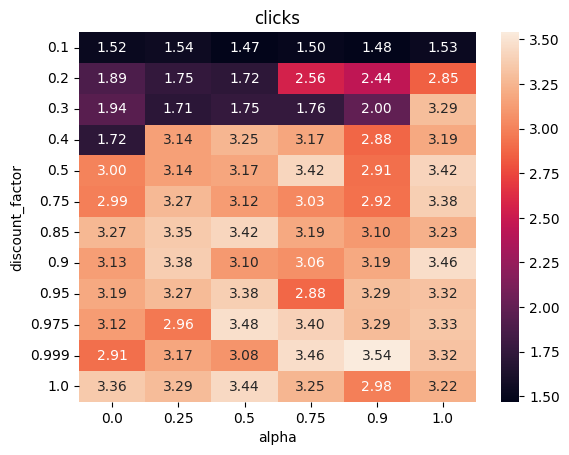

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

sum_df=sum_discount_clicks.groupby([ "discount_factor", "alpha"]).mean().reset_index()

for field in ["early", "middle", "late", "clicks"]:
    heat_map_data = sum_df.pivot(index="discount_factor", columns="alpha", values=field)
    plt.figure()
    plt.title(field)
    sns.heatmap(data=heat_map_data, annot=True, fmt=".2f")
